# Stochastic and Deterministic Augmentation

`imgaug` separates its augmentation into two mode: stochastic and deterministic mode. Both perform nearly the same steps. When calling an augmentation function such as `augment_images(images)` they roughly do:
* **Stochastic Mode**: 
  1. Start with random number generator $R$ (e.g. provided in initializer).
  2. Copy $R$ to $R_c$.
  3. Sample random values from $R_c$.
  4. Augment images based on sampled random values.
  5. Throw away $R_c$.
  6. Forward $R$ (so that the next call leads to different random numbers).
* **Deterministic Mode**:
  1. Start with random number generator $R$ (e.g. provided in initializer).
  2. Copy $R$ to $R_c$.
  3. Sample random values from $R_c$.
  4. Augment images based on sampled random values.
  5. Throw away $R_c$.
  6. **[different]** Keep $R$ unchanged (or reset it to state in (1) if it was somehow changed). The next call will therefore lead to the same samples in step (3).

Hence, if you feed the same batch multiple times into augmenters running in deterministic mode you will get multiple times the exactly same augmentations. Usually, this is not what you want and that is why stochastic mode is the default setting. If however you have two or more batches of images that require the same augmentations, then deterministic mode is the preferred setting. This could be the case e.g. for inputs into siamese networks or for multiple frames from video sequences. The most common use case however are different types data for the same image. E.g. if you have images and bounding boxes on them, the bounding boxes have to be augmented in exactly the same way as the images.

## Visualizing Stochastic and Deterministic Modes

So let's generate an example for the two modes. We will augment two batches of each three identical images. We augment once both batches in stochastic and once both batches in deterministic mode. The result for stochastic mode should differ between the batches, while the one in deterministic mode should be the same for both batches.

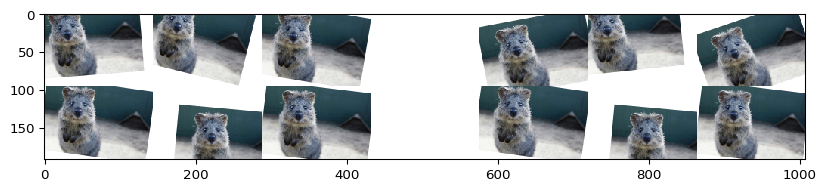

In [1]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
%matplotlib inline
ia.seed(2)

aug = iaa.Affine(translate_px=(-30, 30), rotate=(-20, 20), cval=255)
image = ia.quokka(size=0.15)
batches = [[image] * 3, [image] * 3]  # two batches of each three images

# augment in stochastic mode
images_stochastic = [aug.augment_images(batch) for batch in batches]

# augment in deterministic mode
aug_det = aug.to_deterministic()
images_deterministic = [aug_det.augment_images(batch) for batch in batches]

# visualize
whitespace = np.full(image.shape, 255, dtype=np.uint8)
ia.imshow(
    ia.draw_grid(
        images_stochastic[0] + [whitespace] + images_stochastic[1] +  # first row
        images_deterministic[0] + [whitespace] + images_deterministic[1],  # second row
        rows=2,
        cols=2*3
    )
)

The result above shows stochastic mode in the first row (left: batch 1, right: batch 2) and deterministic mode in the second row. As expected, the augmentations for the two batches in stochastic mode differ, but not in deterministic mode. Note though, that even in deterministic mode the results still differ between the images *within the same batch*.

## Example: Augment Image and Keypoints on it

To provide a more realistic example, we will now augment an image and a set of keypoints on it. The functions for image and keypoint augmentation are in `imgaug` separate from each other and because of that we have to switch to deterministic mode before calling them. Otherwise our keypoints would be augmented differently from the images.

Let's load an example image with keypoints on it and visualize the two.

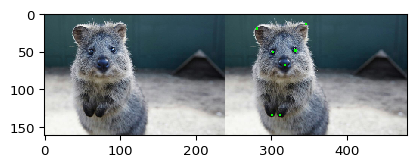

In [2]:
image = ia.quokka(size=0.25)
keypoints = ia.quokka_keypoints(size=0.25)

ia.imshow(
    np.hstack([
        image,
        keypoints.draw_on_image(image)
    ])
)

Now convert the two into batches.

In [3]:
BATCH_SIZE = 4
images_batch = [image] * BATCH_SIZE
keypoints_batch = [keypoints] * BATCH_SIZE

Now augment them using affine transformations. We pick a random rotation from a set of possible rotations (multiples of 15). We also use here stochastic mode first and will see further below that this is a bad choice when augmenting images and corresponding keypoints.

In [4]:
aug = iaa.Affine(rotate=[0, 15, 30, 45, 60])

# stochastic mode
images_aug1 = aug.augment_images(images_batch)
images_aug2 = aug.augment_images(images_batch)
images_aug3 = aug.augment_images(images_batch)
keypoints_aug1 = aug.augment_keypoints(keypoints_batch)
keypoints_aug2 = aug.augment_keypoints(keypoints_batch)
keypoints_aug3 = aug.augment_keypoints(keypoints_batch)

And now we visualize the results as a grid. Each row contains the results of one augmented batch.

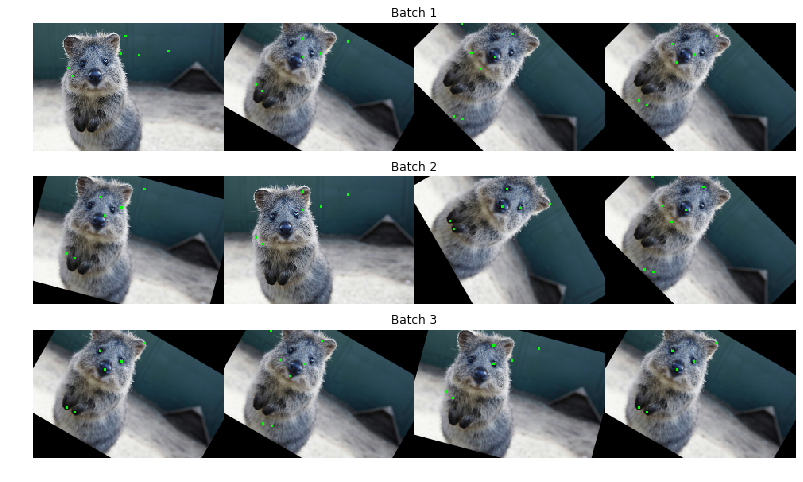

In [5]:
import matplotlib.pyplot as plt

# draw keypoints on images and convert the results to a single image
def draw_and_merge(ims, kps):
    return np.hstack([kp_i.draw_on_image(im_i) for im_i, kp_i in zip(ims, kps)])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axes[0].imshow(draw_and_merge(images_aug1, keypoints_aug1))
axes[1].imshow(draw_and_merge(images_aug2, keypoints_aug2))
axes[2].imshow(draw_and_merge(images_aug3, keypoints_aug3))
for i in range(3):
    axes[i].set_title("Batch %d" % (i+1,))
    axes[i].axis("off")

Note that the keypoints in most cases do not fit to the image. Sometimes they do, but only due to random chance. Images and keypoints were augmented with different rotations.

We fix this now by executing the same code again, but this time using deterministic mode.

In [6]:
aug_det = aug.to_deterministic()  # <- this changed

images_aug1 = aug_det.augment_images(images_batch)
images_aug2 = aug_det.augment_images(images_batch)
images_aug3 = aug_det.augment_images(images_batch)
keypoints_aug1 = aug_det.augment_keypoints(keypoints_batch)
keypoints_aug2 = aug_det.augment_keypoints(keypoints_batch)
keypoints_aug3 = aug_det.augment_keypoints(keypoints_batch)

And run the same visualization code again:

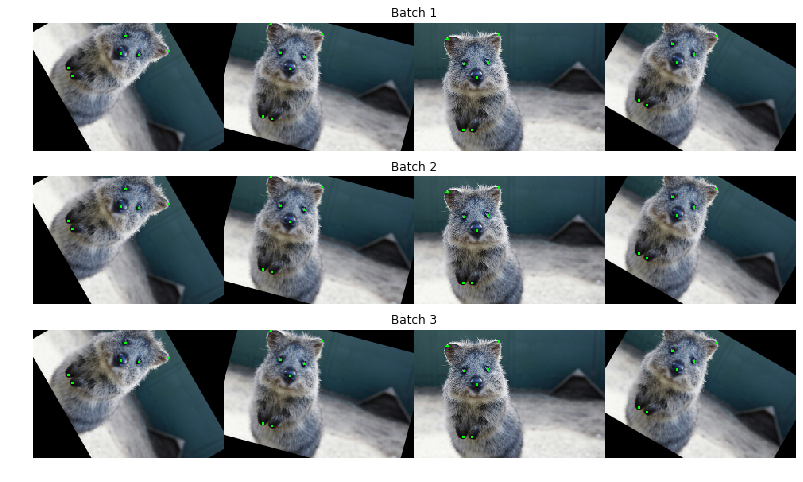

In [7]:
# draw keypoints on images and convert the results to a single image
def draw_and_merge(ims, kps):
    return np.hstack([kp_i.draw_on_image(im_i) for im_i, kp_i in zip(ims, kps)])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axes[0].imshow(draw_and_merge(images_aug1, keypoints_aug1))
axes[1].imshow(draw_and_merge(images_aug2, keypoints_aug2))
axes[2].imshow(draw_and_merge(images_aug3, keypoints_aug3))
for i in range(3):
    axes[i].set_title("Batch %d" % (i+1,))
    axes[i].axis("off")

That's better. The images and keypoints are now aligned, even after augmentation. But the results are still not exactly what we want, because they are the same for all batches. If we trained on this without shuffling the dataset, we would always get the same augmentation for each image between epochs. That would make the augmentation process in most use cases pointless as we would have converted one static dataset into another static dataset. In order to fix this, we have to switch several times into deterministic mode, once per batch. Upon each such switch, the random number generator of the augmenter is set to a different state, which will cause augmentations *between batches* to differ.

In [8]:
aug_det        = aug.to_deterministic()
images_aug1    = aug_det.augment_images(images_batch)
keypoints_aug1 = aug_det.augment_keypoints(keypoints_batch)

aug_det        = aug.to_deterministic()
images_aug2    = aug_det.augment_images(images_batch)
keypoints_aug2 = aug_det.augment_keypoints(keypoints_batch)

aug_det        = aug.to_deterministic()
images_aug3    = aug_det.augment_images(images_batch)
keypoints_aug3 = aug_det.augment_keypoints(keypoints_batch)

And now visualize the results:

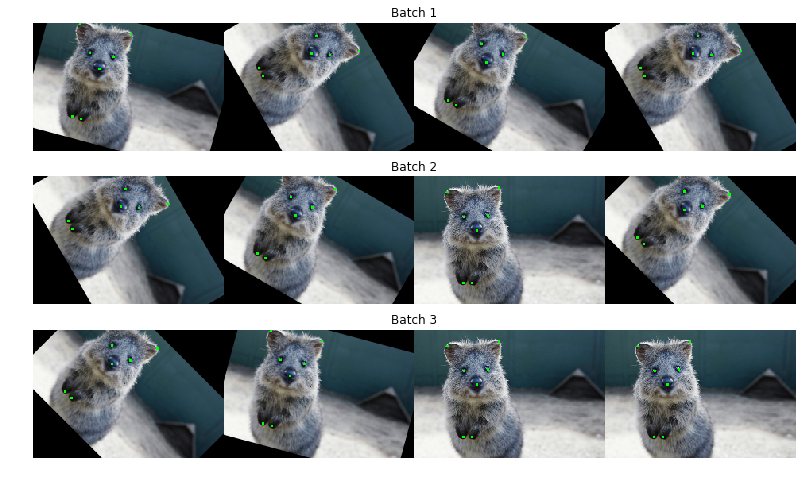

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axes[0].imshow(draw_and_merge(images_aug1, keypoints_aug1))
axes[1].imshow(draw_and_merge(images_aug2, keypoints_aug2))
axes[2].imshow(draw_and_merge(images_aug3, keypoints_aug3))
for i in range(3):
    axes[i].set_title("Batch %d" % (i+1,))
    axes[i].axis("off")

This is what we want: Different augmentations between batches and images, but the same one for each image and the keypoints on it. In a proper experiment, you would of course not manually call `to_deterministic()` three times, but simply place the call inside a training loop, after loading the next batch of data. Just remember to not place it outside the loop or you will get the same augmentations for each batch!